# Music Project to predict popularity of songs

In [1]:
# Load Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import LdaModel
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
from gensim import corpora
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
from googletrans import Translator
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer



In [2]:
#Import dataset
df = pd.read_csv("spotify_songs_traslated_clean_emotions.csv")

### Text Analytics Part 1

In [ ]:
"""
df = pd.read_csv("spotify_songs.csv")
    #Step1: Missing values
print(df.isnull().sum())
df.dropna(subset=["lyrics"], inplace=True)

    #Step2: Check duplicates
duplicates = df[df.duplicated(subset=['lyrics'],keep=False)]
        #Analysis: Some songs repeat several times, but each is a different version of music. Important for analysis of the sound

    #Step3: Language of the lyrics
pd.crosstab(index = df['language'], columns = 'counts')
        #Only "en" and "es" have large amount of datasets
languages=['en','es']
df=df[df['language'].isin(languages) ]

        #Translate song lyrics (from spanish to english)
df.index = np.arange(0, len(df))
translator=Translator()
df['lyrics_traslated']=''

for i in range(len(df)):
    if df['language'][i]=='es':
        text=df['lyrics'][i]
        try:
            translated_text = translator.translate(text, dest='en').text
            df['lyrics_traslated'][i]=translated_text
        except TypeError:
            df['lyrics_traslated'][i]='No translation available'
    else:
        df['lyrics_traslated'][i]=df['lyrics'][i]

        #154 songs won't be able to translate
n_song = (df['lyrics_traslated'] == 'No translation available').sum()
print(n_song)

df=df[(df['lyrics_traslated'] != 'No translation available')]
df_lyrics=df['lyrics_traslated']
df_lyrics= df_lyrics.str.lower()
"""


In [ ]:
"""
#Get sentiment and emotions
        #0: Stop words that doesnt make sense    
new_stopwords=["know","cause","boom","n't", "yeah", "got","oh​","let","keep","ohh","oooh", 
               "gon","back","make","one","way", "ooh","oh", "come","way","'ve" ,"'re" , 
               "wan","'ll", "'em", "put","tell", "hey", "every", "say", "still","want",
               "ayy", ",", "'",":", "/", "NA"]
    
        #Determinate words with low frequency that maybe dont have any meaning
low_stopwords=list()
for i in df_lyrics:
    words= word_tokenize(i)
    for j in words:
        low_stopwords.append(j)

frequency=collections.Counter(low_stopwords)
for i in frequency: #Words that repeat less than 20 times are not important (asumming)
    if frequency[i] <=20:
        new_stopwords.append(i)
        #To not repeat the same stopwords
new_stopwords=list(dict.fromkeys(new_stopwords))

        #1: Removed stopwords (function)

def remove_stopwords(data):
    nltk.download('punkt')
    nltk.download('stopwords')
    clean_lyrics=list()
        #Stopword in englis (need to add more words)
    stop_words = stopwords.words('english')+new_stopwords
    for i in data:
        words = word_tokenize(i) #Split the text into words
        #remove the stopwords
        words = [clean_w for clean_w in words if clean_w not in stop_words and len(clean_w) > 2]
        lyric= " ".join(words) 
        clean_lyrics.append(lyric)
    
    return clean_lyrics
    
df["clean_lyrics"]=remove_stopwords(df_lyrics)

    ###0. Sentiment Analysis : VADER LEXICON
def analyze_sentiment(data):
    nltk.download('vader_lexicon')
    sid= SentimentIntensityAnalyzer()
    positive=[]
    negative=[]
    neutral= []
    comp_score=[]

    for i in data:
        try:
            negative.append(sid.polarity_scores(i)['neg'])
            neutral.append(sid.polarity_scores(i)['neu'])
            positive.append(sid.polarity_scores(i)['pos'])
            comp_score.append(sid.polarity_scores(i)['compound'])
        except Exception as e:
            negative.append('Nan')
            neutral.append('Nan')
            positive.append('Nan')
            comp_score.append('Nan')
    return positive, negative, neutral, comp_score

df["positive"], df["negative"],df["neutral"], df["compound"] = analyze_sentiment(df["clean_lyrics"])
df=df[(df['negative']!='Nan')]
df["sentiment"] = df["compound"].apply(lambda x: 'Positive' if x>=0.5 else 'Negative' if x<=-0.5 else 'Neutral')

    ###1. Emotion Analysis: Emotion English DistilRoBERTa-base 
def emotion_analysis(data):
# Initialize an emotion classification pipeline
    emotion_classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)    
    anger=[]
    disgust=[]
    fear=[]
    joy=[]
    neutral_emotion=[]
    sadness=[]
    surprise=[]
    
    for i in data:
        try:
            results=emotion_classifier(i)
            anger.append(results[0][0]['score'])
            disgust.append(results[0][1]['score'])
            fear.append(results[0][2]['score'])
            joy.append(results[0][3]['score'])
            neutral_emotion.append(results[0][4]['score'])
            sadness.append(results[0][5]['score'])
            surprise.append(results[0][6]['score'])
        except Exception as e:
            anger.append('NaN')
            disgust.append('NaN')
            fear.append('NaN')
            joy.append('NaN')
            neutral_emotion.append('NaN')
            sadness.append('NaN')
            surprise.append('NaN')
            
    return anger, disgust, fear, joy, neutral_emotion, sadness, surprise

df["anger"], df["disgust"],df["fear"], df["joy"], df["neutral_emotion"], df["sadness"],df["surprise"] = emotion_analysis(df["clean_lyrics"])
df=df[(df['anger']!='NaN')]
       #Generate a new variable with the stronger emotion
n_index=df.index #Index of each song
emotions=['anger','disgust','fear','joy','neutral_emotion','sadness','surprise']
emotion=[]
for i in n_index:
    y=0
    for j in emotions:
        nv=df[j][i]
        if nv > y:
           emo=j #Keep the strong emotion
           y = nv
    emotion.append(emo)
    
df['emotions']=emotion   
"""


### Understanding the data

In [3]:
#Duplicates: same song different version the same name or same lyrics
df = df.drop_duplicates(subset='track_name', keep='first')
df = df.drop_duplicates(subset='lyrics', keep='first')

#Drop irrelevant variables
df = df.drop(columns=['track_id','track_name','lyrics','track_album_id',
                      'track_album_name','playlist_name','playlist_id',
                      'playlist_subgenre','language','lyrics_traslated','positive','negative','neutral','compound',
                      'key','mode','valence','tempo'], axis=1)

#First Feature enginering
    #Songs higher than 62 will be consider as popular
df['is_popular'] = df['track_popularity'].apply(lambda x: 1 if x >= 62 else 0)
    #Consider the decade of each song
df['year'] = df['track_album_release_date'].str.extract(r'(\d{4})')
df['year'] = df['year'].astype(int)
bins = [1960, 1980, 1990, 2000, 2010, 2024]
labels = ['1970s', '1980s', '1990s', '2000s','2010s']
df['decade'] = pd.cut(df['year'], bins = bins, labels = labels, right=False)
df=df.drop(columns=['year'])

#Missing values
df=df.dropna()
df=df.drop(columns=['track_artist','track_album_release_date','emotions'], axis=1)
print(df.isnull().sum())


track_popularity    0
playlist_genre      0
danceability        0
energy              0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
duration_ms         0
clean_lyrics        0
sentiment           0
anger               0
disgust             0
fear                0
joy                 0
neutral_emotion     0
sadness             0
surprise            0
is_popular          0
decade              0
dtype: int64


### Text Analytics Part 2: Themes

In [47]:
###THEMES OR TOPICS
num_topics=8
lyrics_data = list(zip(df['clean_lyrics']))
lyrics_data=pd.DataFrame(lyrics_data, columns=['clean_lyrics']) 
lemmatizer = WordNetLemmatizer()
processed_lyrics = []
for song in df['clean_lyrics']:
    tokens = word_tokenize(song.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in string.punctuation]
    processed_lyrics.append(tokens)
    # Create a dictionary and corpus
dictionary = corpora.Dictionary(processed_lyrics)
corpus = [dictionary.doc2bow(text) for text in processed_lyrics]
    # Train the LDA model
lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=5)

topics={}
for idx, topic in lda.print_topics(-1):
    topic_dict = {}
    words_and_weights = topic.split(' + ')
    for word_weight in words_and_weights:
        weight, word = word_weight.split('*')
        topic_dict[word.strip()] = float(weight)  # store the weight as a float
        # Add this topic dictionary to the main topics dictionary, using the topic index (idx + 1) as the key
    topics[f"Topic {idx + 1}"] = topic_dict

for topic_id in range(num_topics):
    df[f"Topic {topic_id + 1}"] = 0.0  # Initialize topic columns

df = df.reset_index(drop=True)
for i, song_bow in enumerate(corpus):
    topic_probs = lda.get_document_topics(song_bow)
    for topic_id, prob in topic_probs:
        df.loc[i, f"Topic {topic_id + 1}"] = prob

df=df.drop(columns=['clean_lyrics','track_popularity'])


In [49]:
#Obtain the topic with LLM (ChatGPT)
t={}
topic_text=[]
for i in topics.keys():
    t=topics[i]
    topic_line=", ".join([f"{word} ({t[word]:.2f})" for word in t.keys()])
    topic_text.append(f"Topic {i} : {topic_line}")
final_text="\n".join(topic_text)
print(final_text)

topics_LLM=['Time, Life, and Reflection', 'People, God, and the World', 'Dance, Movement, and Romance', 'Night, Wildness, and Energy',
            'Street Life and Survival','Feelings, Good Times, and Love', 'Endless Love and Longing', 'Dreams, Light, and Heartbreak']

print("Number of themes in the dataset: Words for each theme and weight")
z=0
for i in topics.keys():
    print(f"Theme: {i}, {topics_LLM[z]}")
    themes=pd.DataFrame.from_dict(topics[i], orient='index')
    z+=1
    print(themes)
#Rename columns
new_names = {f'Topic {i+1}': f'T{i+1}_{topics_LLM[i]}' for i in range(8)}
df.rename(columns=new_names, inplace=True)


Topic Topic 1 : "take" (0.02), "see" (0.01), "time" (0.01), "going" (0.01), "day" (0.01), "look" (0.01), "without" (0.01), "like" (0.01), "life" (0.01), "everything" (0.01)
Topic Topic 2 : "get" (0.04), "man" (0.02), "like" (0.01), "see" (0.01), "world" (0.01), "god" (0.01), "around" (0.01), "people" (0.01), "life" (0.01), "time" (0.01)
Topic Topic 3 : "baby" (0.03), "dance" (0.03), "like" (0.03), "girl" (0.03), "body" (0.02), "move" (0.02), "give" (0.02), "get" (0.01), "hand" (0.01), "take" (0.01)
Topic Topic 4 : "night" (0.05), "long" (0.02), "another" (0.02), "well" (0.02), "beat" (0.01), "black" (0.01), "wild" (0.01), "roll" (0.01), "late" (0.01), "get" (0.01)
Topic Topic 5 : "like" (0.03), "nigga" (0.03), "bitch" (0.02), "shit" (0.02), "fuck" (0.02), "get" (0.01), "money" (0.01), "hit" (0.01), "as" (0.01), "boy" (0.01)
Topic Topic 6 : "good" (0.04), "girl" (0.03), "need" (0.02), "feel" (0.02), "tonight" (0.02), "right" (0.02), "get" (0.02), "like" (0.02), "baby" (0.02), "mind" (0.

### Exploratory Analysis

##### Genre: some genres have a higher popularity on average than others

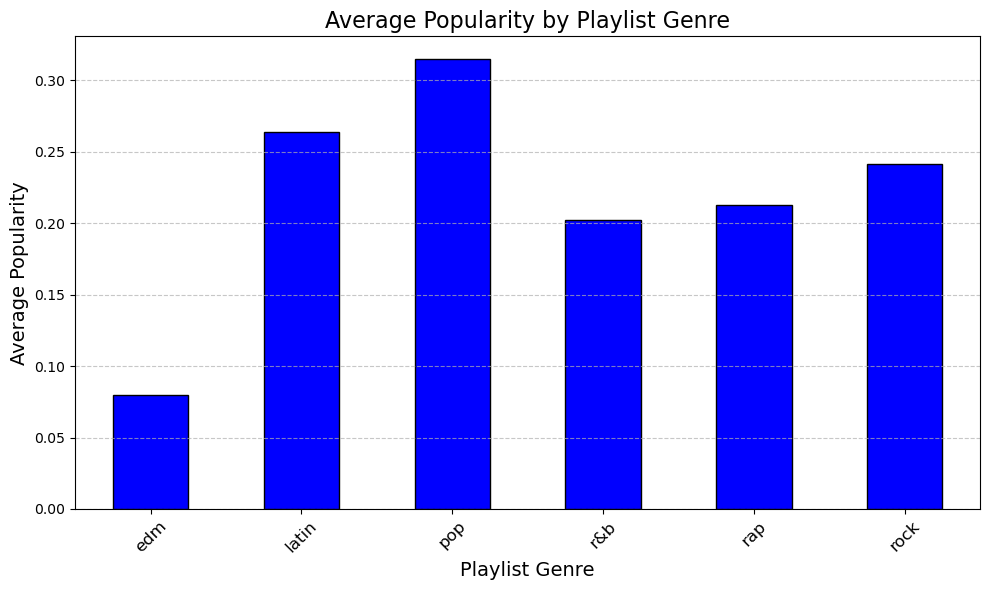

In [50]:
avg_popularity = df.groupby('playlist_genre')['is_popular'].mean()
plt.figure(figsize=(10, 6))
avg_popularity.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Average Popularity by Playlist Genre', fontsize=16)
plt.xlabel('Playlist Genre', fontsize=14)
plt.ylabel('Average Popularity', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


##### Decade: in different times the populary has change

C:\Users\gpnc_\AppData\Local\Temp\ipykernel_34940\1472877849.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decade_popularity = df.groupby('decade')['is_popular'].mean().reset_index()
C:\Users\gpnc_\AppData\Local\Temp\ipykernel_34940\1472877849.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=decade_popularity, x='decade', y='is_popular', palette='viridis')


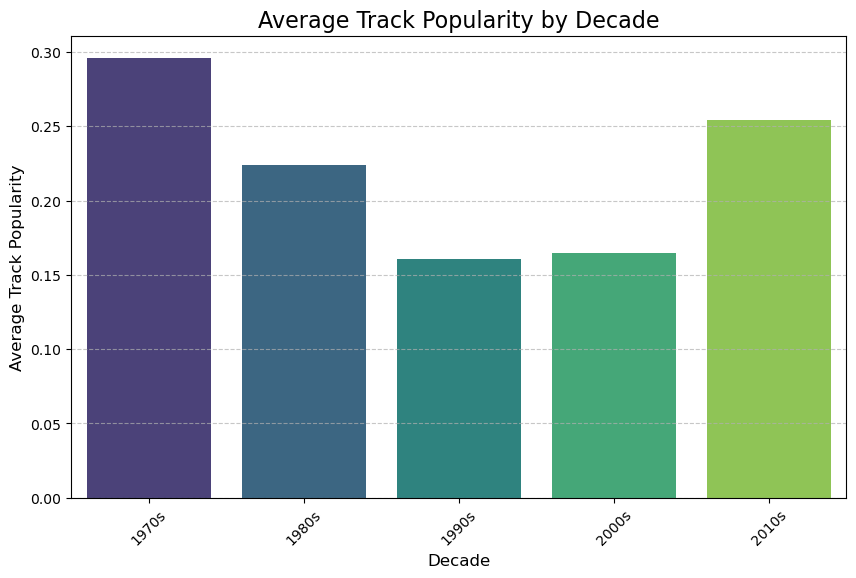

In [51]:
decade_popularity = df.groupby('decade')['is_popular'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=decade_popularity, x='decade', y='is_popular', palette='viridis')
plt.title('Average Track Popularity by Decade', fontsize=16)
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Average Track Popularity', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##### Sentiments: Not important, its balance

C:\Users\gpnc_\AppData\Local\Temp\ipykernel_34940\1306147787.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_popularity, x='sentiment', y='is_popular', palette='viridis')


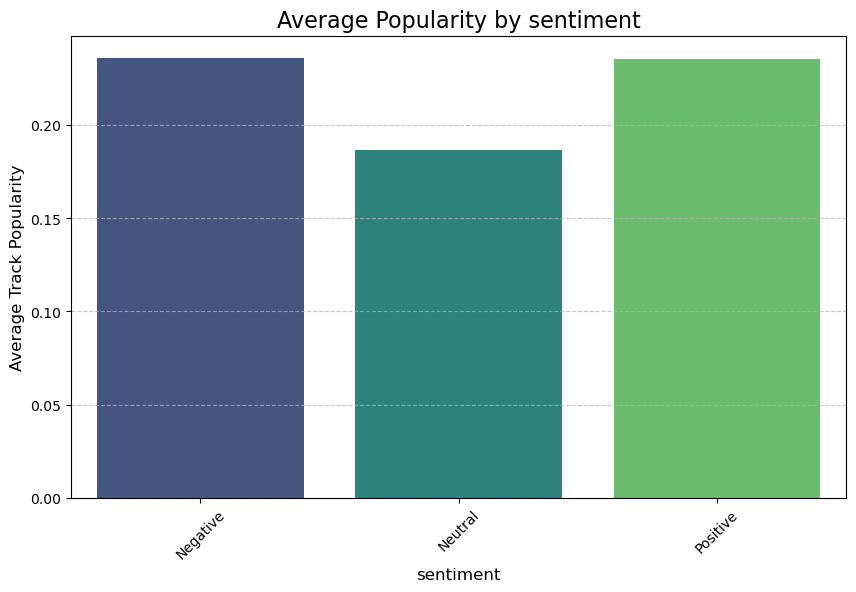

In [52]:
sentiment_popularity = df.groupby('sentiment')['is_popular'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=sentiment_popularity, x='sentiment', y='is_popular', palette='viridis')
plt.title('Average Popularity by sentiment', fontsize=16)
plt.xlabel('sentiment', fontsize=12)
plt.ylabel('Average Track Popularity', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()  

##### Exploratory Data Analysis (EDA) - Numerical Variables

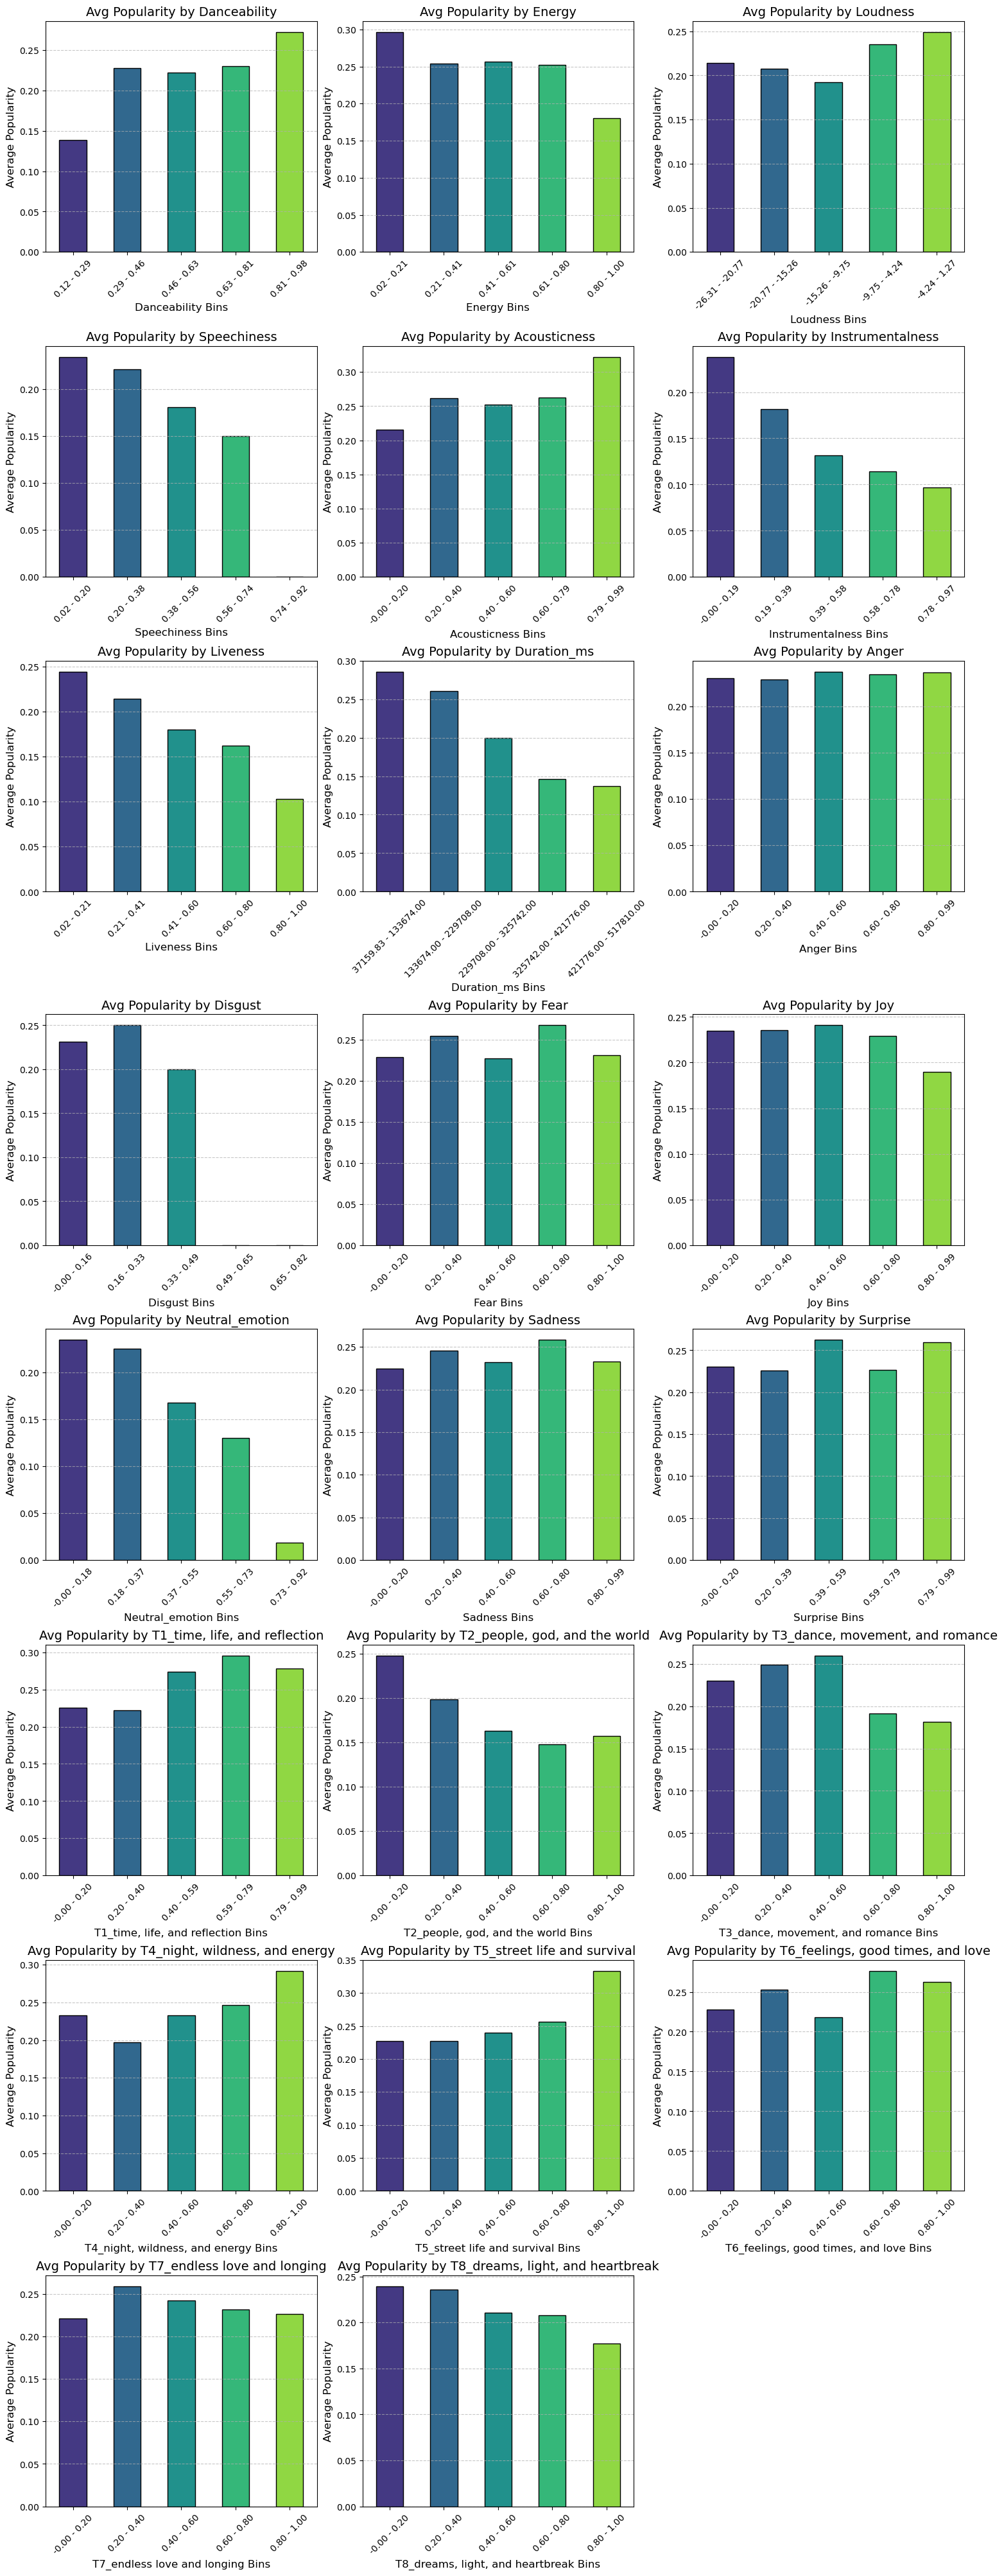

In [53]:
# Filter numeric columns
df_num = df.select_dtypes(include=['number'])

# Count the number of numeric columns excluding 'is_popular'
num_columns = [col for col in df_num.columns if col != 'is_popular']

# Create a figure and subplots
n_cols = 3  # Number of plots per row
n_rows = (len(num_columns) + n_cols - 1) // n_cols  # Determine rows based on number of columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)

# Flatten axes for easy iteration
axes = axes.flatten()

for idx, column in enumerate(num_columns):
    bins, bin_edges = pd.cut(df[column], bins=5, retbins=True, labels=False)
    bin_ranges = [f"{bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}" for i in range(len(bin_edges) - 1)]
    df['bins'] = bins
    avg_popularity = df.groupby('bins')['is_popular'].mean()
    palette = sns.color_palette("viridis", len(bin_ranges))

    # Select the current subplot
    ax = axes[idx]

    # Plot on the current axis
    avg_popularity.plot(kind='bar', color=palette, edgecolor='black', ax=ax)

    ax.set_title(f'Avg Popularity by {column.capitalize()}', fontsize=14)
    ax.set_xlabel(f'{column.capitalize()} Bins', fontsize=12)
    ax.set_ylabel('Average Popularity', fontsize=12)

    ax.set_xticks(range(len(bin_ranges)))
    ax.set_xticklabels(bin_ranges, rotation=45, fontsize=10)

    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Remove bins column
    df.drop(columns=['bins'], inplace=True)

# Hide any unused subplots
for idx in range(len(num_columns), len(axes)):
    fig.delaxes(axes[idx])

plt.show()


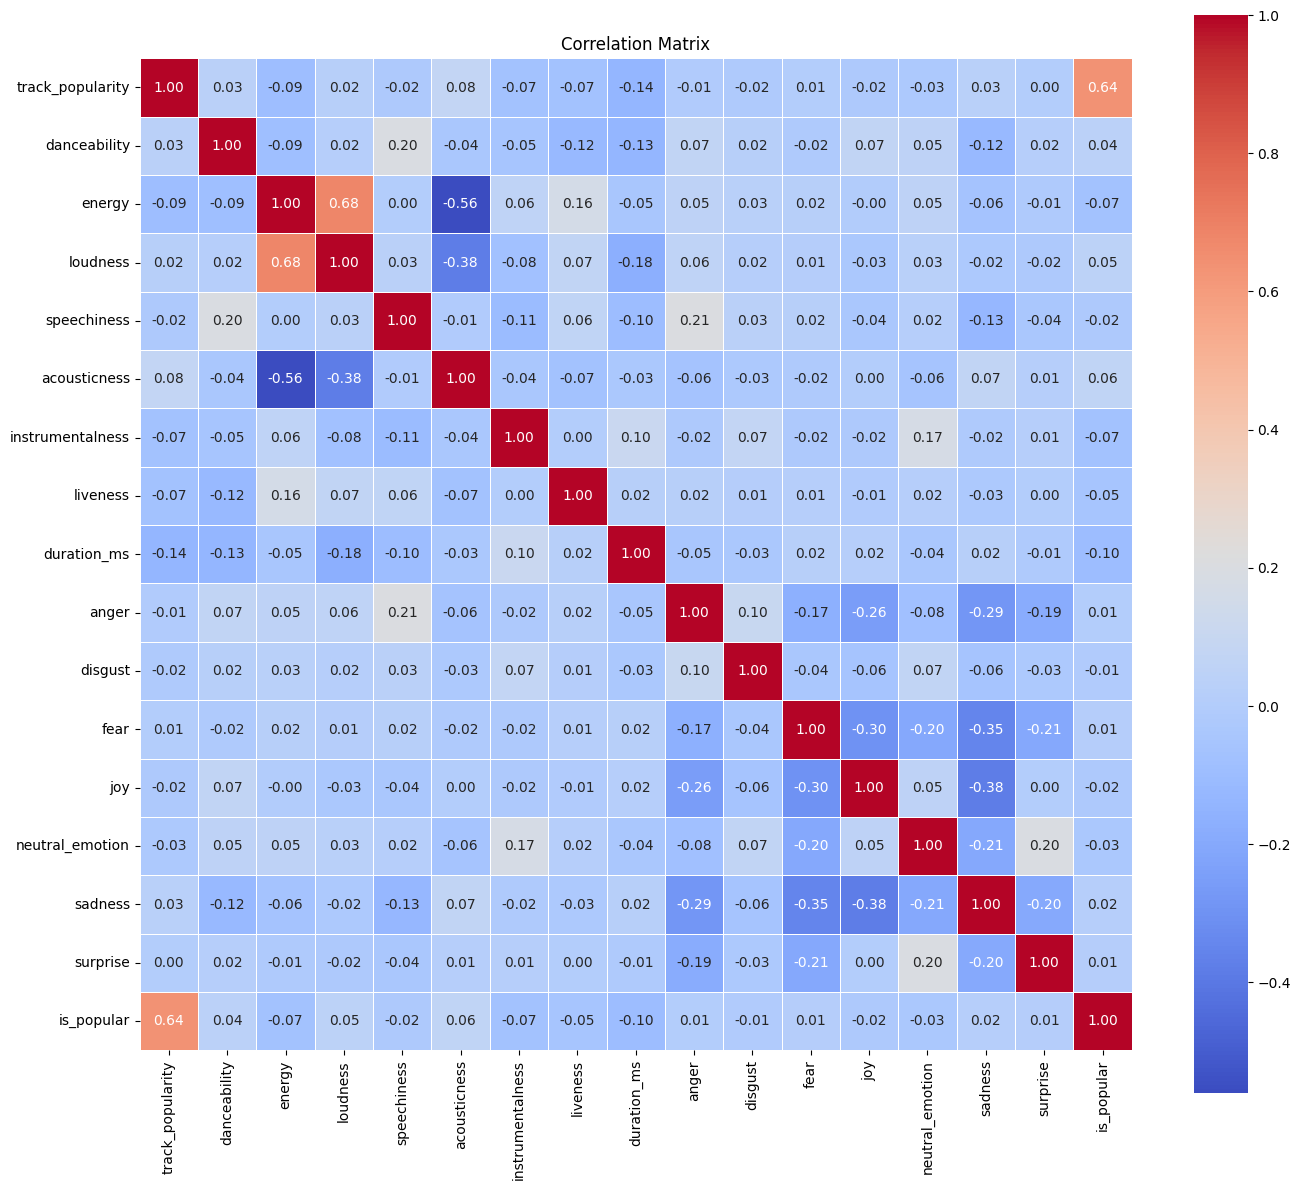

In [4]:
df_num = df.select_dtypes(include=['number'])
#sp_dataset_num.describe()
correlation_matrix = df_num.corr()

# Set up the matplotlib figure
plt.figure(figsize=(16, 14))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.4)

# Add title and labels
plt.title('Correlation Matrix')
plt.show()


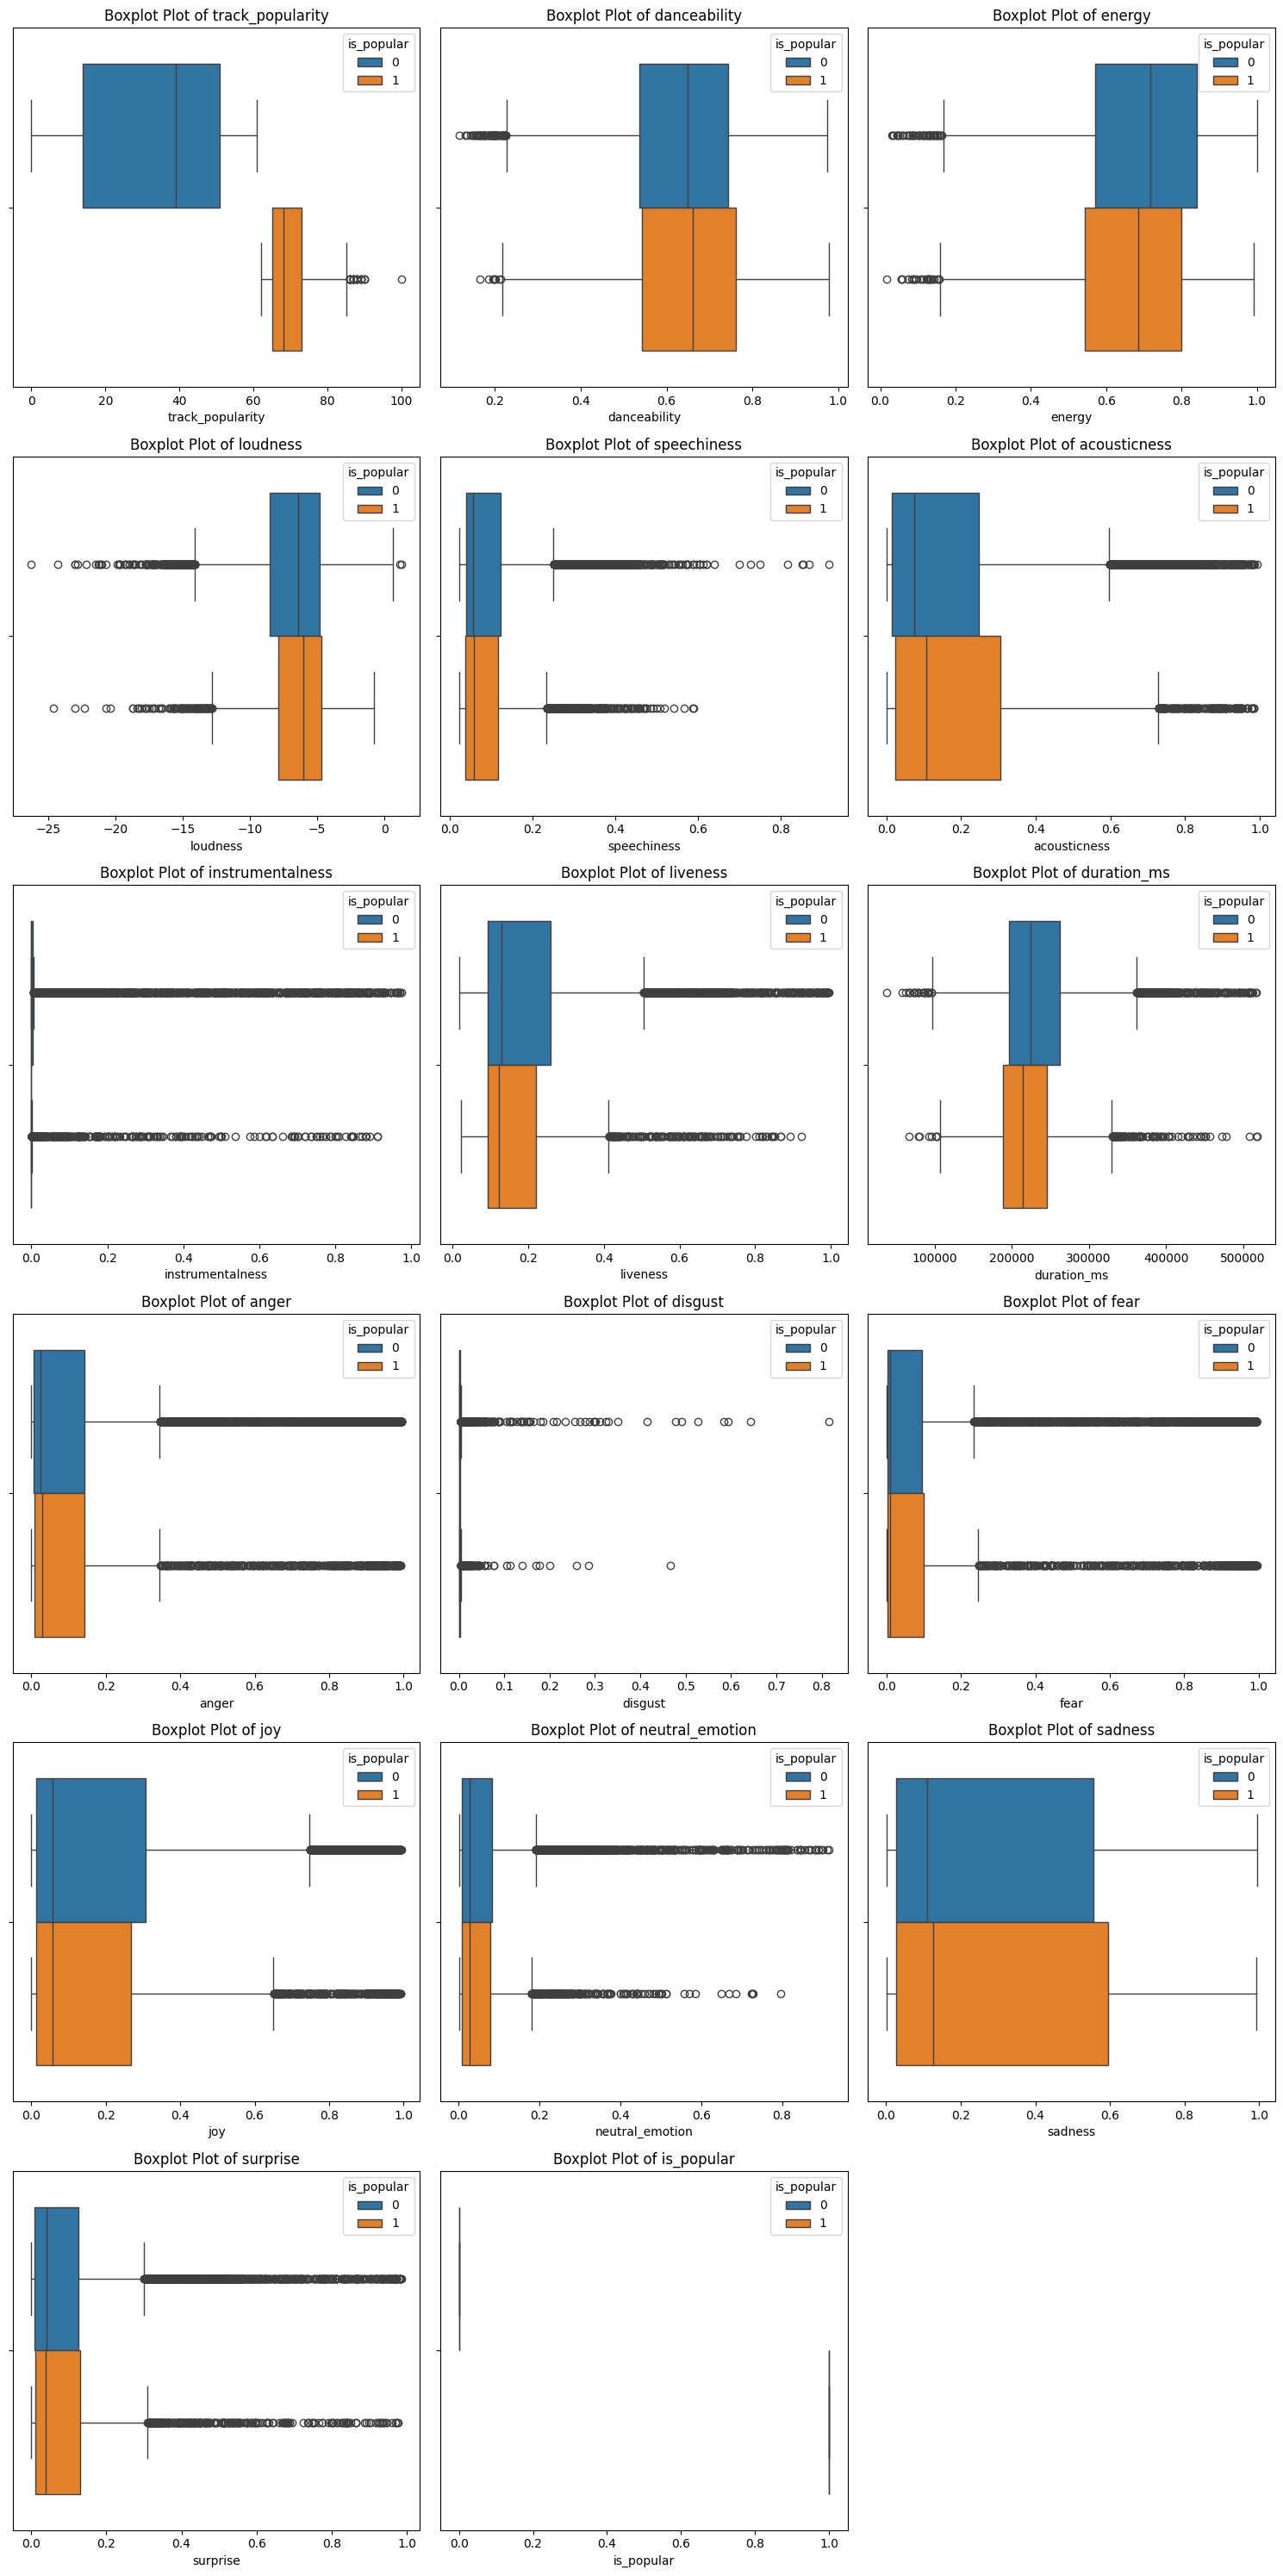

In [5]:
#BOXPLOTS
num_vars = df_num.shape[1]
cols = 3
rows = (num_vars + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(df_num.columns):
    sns.boxplot(data=df_num, x=col, ax=axes[i], hue=df_num['is_popular'])
    axes[i].set_title(f'Boxplot Plot of {col}')
    axes[i].set_xlabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Feature Selection with random forest

In [57]:
#Dummyfing
y=df['is_popular']
X=df.drop(columns=['is_popular'], axis=1)
X=pd.get_dummies(X, drop_first=True)

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Isolation Forest to remove outliers
iforest = IsolationForest(n_estimators=100, contamination=.05)
pred=iforest.fit(X_train)
outliers_train = pred.predict(X_train)
outliers_test = pred.predict(X_test)
outliers_value_train = outliers_train != -1
outliers_value_test = outliers_test != -1

X_train=X_train[outliers_value_train]
y_train=y_train[outliers_value_train]
X_test=X_test[outliers_value_test]
y_test=y_test[outliers_value_test]

#Balance the data
rus = RandomUnderSampler(random_state=0)
X_train, y_train= rus.fit_resample(X_train, y_train)

#Standarize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Random Forest
rf = RandomForestClassifier(random_state=0)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30],
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='recall', cv=5, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params) #max_depth:20 n_estimators=200

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest")
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .....................max_depth=20, n_estimators=100; total time=   3.4s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.7s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.8s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.7s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.7s
[CV] END .....................max_depth=20, n_estimators=200; total time=   1.5s
[CV] END .....................max_depth=20, n_estimators=200; total time=   1.5s
[CV] END .....................max_depth=20, n_estimators=200; total time=   1.6s
[CV] END .....................max_depth=20, n_estimators=200; total time=   1.6s
[CV] END .....................max_depth=20, n_estimators=200; total time=   1.6s
[CV] END .....................max_depth=30, n_estimators=100; total time=   0.7s
[CV] END .....................max_depth=30, n_est

                              Feature  Importance
7                         duration_ms    0.053793
1                              energy    0.053376
4                        acousticness    0.052204
0                        danceability    0.049234
2                            loudness    0.048542
3                         speechiness    0.047592
6                            liveness    0.047341
10                               fear    0.044614
9                             disgust    0.043585
8                               anger    0.042986
14                           surprise    0.042704
5                    instrumentalness    0.042568
11                                joy    0.042253
12                    neutral_emotion    0.042147
13                            sadness    0.040659
22   T8_Dreams, Light, and Heartbreak    0.037767
21        T7_Endless Love and Longing    0.034034
16      T2_People, God, and the World    0.032514
15      T1_Time, Life, and Reflection    0.031185


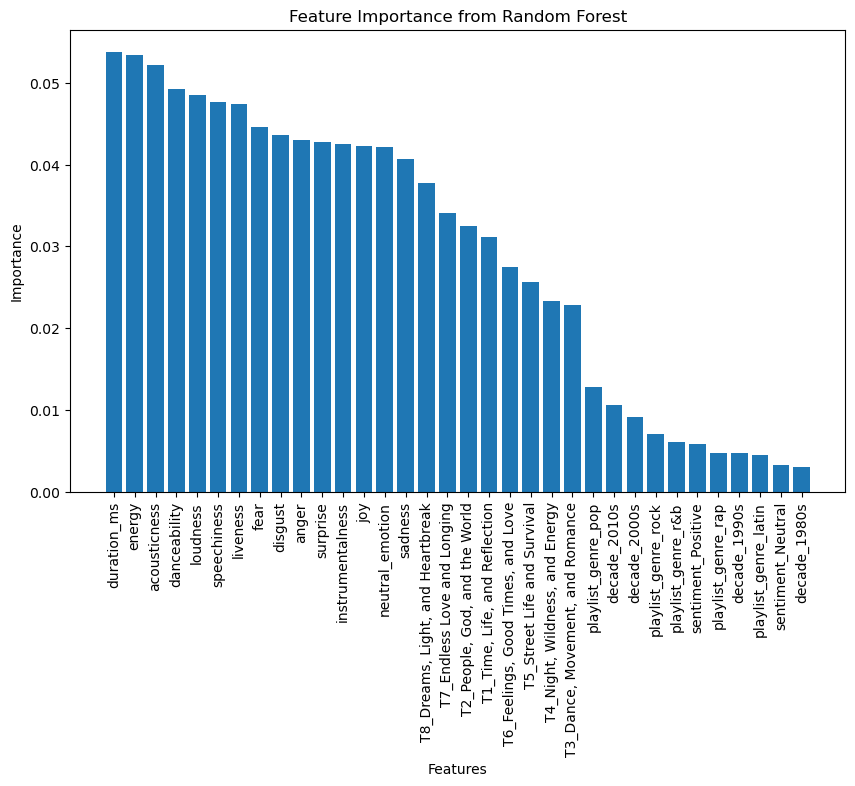

In [60]:
#Feature importance
importances = best_rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

plt.figure(figsize=(10, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.xticks(rotation=90)
plt.show()

### Selecting the variables for the the PCA and Modeling

#### The variables were selected based on what was discovered in the Random Forest (Feature Selection) and the EDA using the visulizations (Boxplots). We decided to remove instrumentalness because of its high quantity of outliers and almost equal avergage of instrumentalnes for both popular and unpopular songs.

In [19]:
vars_to_use = df_num.filter(items=["loudness","acousticness", "danceability", "duration_ms", "energy", "liveness", "speechiness", 'is_popular', 'joy', 'sadness', 'fear', 'neutral_emotion','surprise','anger', 'disgust'], axis=1)
X = vars_to_use.drop(columns=['is_popular'], axis=1)
y = vars_to_use['is_popular']
X.head(5)

,loudness,acousticness,danceability,duration_ms,energy,liveness,speechiness,joy,sadness,fear,neutral_emotion,surprise,anger,disgust
0,-4.739,0.01170,0.303,373512,0.880,0.3470,0.0442,0.945038,0.039460,0.000430,0.005614,0.006927,0.001758,0.000773
1,-7.504,0.00432,0.845,262467,0.652,0.4890,0.2160,0.083610,0.108948,0.567910,0.072490,0.075087,0.088948,0.003007
2,-5.819,0.68900,0.425,243067,0.378,0.0664,0.0341,0.109074,0.427314,0.042142,0.026105,0.145843,0.248703,0.000819
3,-1.993,0.03700,0.760,193160,0.887,0.1380,0.0409,0.014813,0.343923,0.575042,0.015096,0.010109,0.032902,0.008114
4,-6.157,0.28000,0.496,224720,0.639,0.0975,0.0550,0.003357,0.007550,0.985908,0.000846,0.000912,0.001245,0.000182


#### Principal Component Analysis

#### PCA will help us provide what should be the profile or behavior of the popular songs so the new artists can have a point of reference of how the relationships between the variables make a song popular.

#### PCA: Popular Songs

In [7]:
X_yes= vars_to_use[vars_to_use['is_popular']==1]
X_yes = X_yes.drop(columns=['is_popular'],axis=1)

In [8]:
X_yes = X_yes.dropna()
# Standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

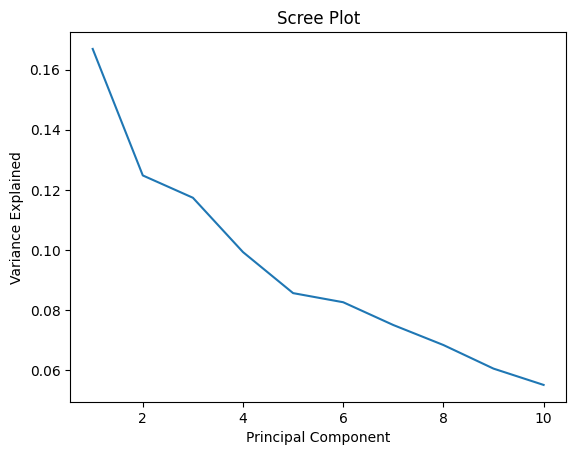

In [9]:
# Principal component analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(scaled_X)

# Create a scree plot
import matplotlib.pyplot as plt
import numpy as np
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [10]:
pca.explained_variance_ratio_

array([0.166848  , 0.12479616, 0.11738306, 0.0993216 , 0.08568248,
       0.08265295, 0.07508185, 0.06843371, 0.06059345, 0.0551721 ])

In [11]:
pca = PCA(n_components=2)
pca.fit(scaled_X)
X_new = pca.transform(scaled_X)

In [12]:
# Scale Data
x_scaled = StandardScaler().fit_transform(X)

# Perform PCA on Scaled Data
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_X)

# Principal components correlation coefficients
loadings = pca.components_

# Number of features before PCA
n_features = pca.n_features_in_

feature_names = X_yes.columns

# PC names
pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

# Match PC names to loadings
pc_loadings = dict(zip(pc_list, loadings))

# Matrix of corr coefs between feature names and PCs
loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')
loadings_df

,PC1,PC2
feature_names,,
loudness,0.552205,0.072117
acousticness,-0.496523,-0.030475
danceability,0.014881,-0.302216
duration_ms,-0.109268,0.120535
energy,0.600452,0.086892
liveness,0.150893,0.059126
speechiness,0.084263,-0.168297
joy,-0.014730,-0.474446
sadness,-0.142732,0.507558


In [13]:
# Create DataFrame from PCA
pca_df = pd.DataFrame(
    data=pca_features,
    columns=['PC1', 'PC2'])

# Scale PCS into a DataFrame
pca_df_scaled = pca_df.copy()

scaler_df = pca_df[['PC1', 'PC2']]
scaler = 1 / (scaler_df.max() - scaler_df.min())

for index in scaler.index:
    pca_df_scaled[index] *= scaler[index]

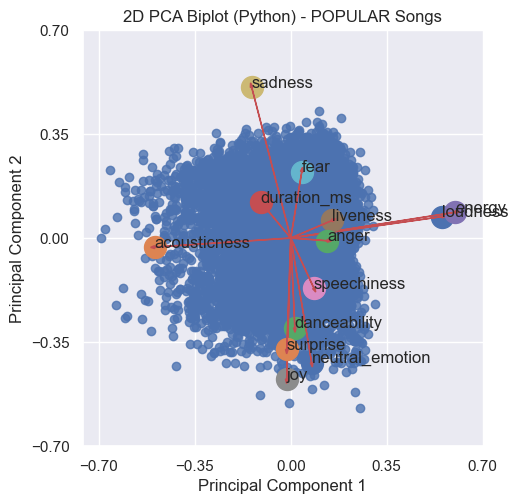

In [14]:
# 2D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

xs = loadings[0]
ys = loadings[1]

sns.lmplot(
    x='PC1',
    y='PC2',
    data=pca_df_scaled,
    fit_reg=False,
    )

for i, varnames in enumerate(feature_names):
    plt.scatter(xs[i], ys[i], s=250)
    plt.arrow(
        0, 0, # coordinates of arrow base
        xs[i], # length of the arrow along x
        ys[i], # length of the arrow along y
        color='r',
        head_width=0.01
        )
    plt.text(xs[i], ys[i], varnames)

xticks = np.linspace(-0.7, 0.7, num=5)
yticks = np.linspace(-0.7, 0.7, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.title('2D PCA Biplot (Python) - POPULAR Songs')
plt.show()

###  Modeling

In [26]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Isolation Forest to remove outliers
iforest = IsolationForest(n_estimators=100, contamination=.05)
pred=iforest.fit(X_train)
outliers_train = pred.predict(X_train)
outliers_test = pred.predict(X_test)
outliers_value_train = outliers_train != -1
outliers_value_test = outliers_test != -1

X_train=X_train[outliers_value_train]
y_train=y_train[outliers_value_train]
X_test=X_test[outliers_value_test]
y_test=y_test[outliers_value_test]

#Balance the data
rus = RandomUnderSampler(random_state=0)
X_train, y_train= rus.fit_resample(X_train, y_train)

#Standarize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Model 1: Random Forest

In [27]:
#Random Forest
rf = RandomForestClassifier(random_state=0)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30],
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='recall', cv=5, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_rf = grid_search.best_estimator_

# Get predicted probabilities
probabilities = best_rf.predict_proba(X_test)

# Adjust the threshold
threshold = 0.5  
predictions = (probabilities[:, 1] >= threshold).astype(int)

y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest")
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.9s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.8s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.8s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.9s
[CV] END .....................max_depth=20, n_estimators=100; total time=   0.8s
[CV] END .....................max_depth=20, n_estimators=200; total time=   1.8s
[CV] END .....................max_depth=20, n_estimators=200; total time=   1.8s
[CV] END .....................max_depth=20, n_estimators=200; total time=   1.8s
[CV] END .....................max_depth=20, n_estimators=200; total time=   1.9s
[CV] END .....................max_depth=20, n_estimators=200; total time=   1.8s
[CV] END .....................max_depth=30, n_estimators=100; total time=   0.9s
[CV] END .....................max_depth=30, n_est

### Model 2: Logistic Regression

LogisticRegression
Accuracy: 0.5586638830897703
              precision    recall  f1-score   support

           0       0.84      0.54      0.66      1873
           1       0.27      0.62      0.38       522

    accuracy                           0.56      2395
   macro avg       0.56      0.58      0.52      2395
weighted avg       0.71      0.56      0.60      2395

[[1013  860]
 [ 197  325]]


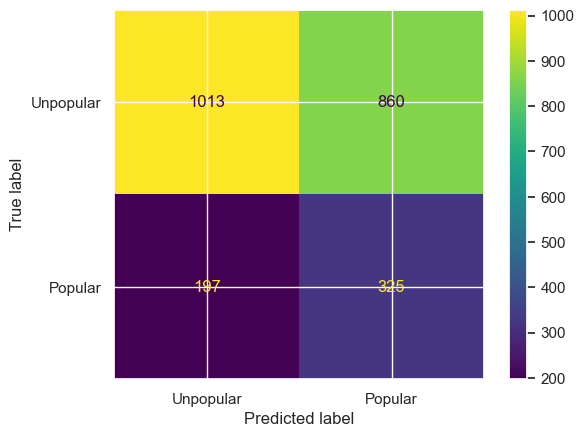

In [28]:
#Logistic Regression
#Logistic Regression
lr = LogisticRegression()

lr.fit(X_train, y_train)

# Get predicted probabilities
probabilities = lr.predict_proba(X_test)

# Adjust the threshold
threshold = 0.5  
predictions = (probabilities[:, 1] >= threshold).astype(int)

y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(y_test, y_pred)
print("LogisticRegression")
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, predictions, labels=lr.classes_)
custom_labels = ['Unpopular', 'Popular']
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=custom_labels)
disp.plot()

### Model 3: Logistic Regression (Ridge)

In [29]:
lr=LogisticRegression(penalty='l2',C=12, solver='lbfgs')
model_lr=lr.fit(X_train,y_train)
y_pred=model_lr.predict(X_test) #The value predict by the model
y_pred_prob = model_lr.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)

print("Logistic Regression with Ridge")
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Logistic Regression with Ridge
Accuracy: 0.5582463465553236
              precision    recall  f1-score   support

           0       0.84      0.54      0.66      1873
           1       0.27      0.62      0.38       522

    accuracy                           0.56      2395
   macro avg       0.56      0.58      0.52      2395
weighted avg       0.71      0.56      0.60      2395



In [146]:
coefficients = model_lr.coef_[0]
odds_ratios = np.exp(coefficients)
feature_names = X.columns

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios,
})
print(coef_df)



            Feature  Coefficient  Odds Ratio
0          loudness     0.392872    1.481229
1      acousticness     0.083264    1.086829
2      danceability     0.073733    1.076520
3       duration_ms    -0.199953    0.818769
4            energy    -0.322942    0.724016
5          liveness    -0.139191    0.870062
6       speechiness    -0.086990    0.916687
7               joy     0.009364    1.009408
8           sadness     0.002723    1.002727
9              fear     0.010780    1.010839
10  neutral_emotion    -0.084288    0.919167
11         surprise     0.018042    1.018206
12            anger    -0.007894    0.992137
13          disgust     0.029600    1.030042


In [140]:
genres = df['playlist_genre'].unique()
for genre in genres:
    print(f"\nProcessing for genre: {genre}")
    genre_df = df[df['playlist_genre'] == genre]
    
    y = genre_df['is_popular']
    X = genre_df.drop(columns=['is_popular', 'playlist_genre'], axis=1)  # Drop 'genre' as it's not a feature
    X = pd.get_dummies(X, drop_first=True)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    # Isolation Forest to remove outliers
    iforest = IsolationForest(n_estimators=100, contamination=0.05, random_state=0)
    outliers_train = iforest.fit_predict(X_train) != -1
    outliers_test = iforest.fit_predict(X_test) != -1

    X_train = X_train[outliers_train]
    y_train = y_train[outliers_train]
    X_test = X_test[outliers_test]
    y_test = y_test[outliers_test]

    # Balance the data
    rus = RandomUnderSampler(random_state=0)
    X_train, y_train = rus.fit_resample(X_train, y_train)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #Logistic regression with RIDGE
    lr=LogisticRegression(penalty='l2',C=12, solver='lbfgs')
    model_lr=lr.fit(X_train,y_train)
    y_pred=model_lr.predict(X_test) #The value predict by the model
    y_pred_prob = model_lr.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)

    print("Logistic Regression with Ridge")
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred))




Processing for genre: rock
Logistic Regression with Ridge
Accuracy: 0.5258855585831063
              precision    recall  f1-score   support

           0       0.78      0.51      0.62       554
           1       0.27      0.56      0.37       180

    accuracy                           0.53       734
   macro avg       0.53      0.54      0.49       734
weighted avg       0.66      0.53      0.56       734


Processing for genre: r&b
Logistic Regression with Ridge
Accuracy: 0.6057553956834533
              precision    recall  f1-score   support

           0       0.86      0.61      0.72       562
           1       0.26      0.57      0.36       133

    accuracy                           0.61       695
   macro avg       0.56      0.59      0.54       695
weighted avg       0.74      0.61      0.65       695


Processing for genre: pop
Logistic Regression with Ridge
Accuracy: 0.590851334180432
              precision    recall  f1-score   support

           0       0.75      0